# **Time Series Forecasting with RNNs and GRUs**
*In this exercise, we implement and compare recurrent neural network models for time series prediction.*

You can ask your questions in Telegram : @FatemehNikkhoo


## Name = `MohammadParsa Dini`

### StudentId = `400101204`

# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Set up device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the Dataset

In [29]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv('./airline_passengers.csv', header=0)#, parse_dates=['Month'])

# Preprocessing pipeline:
#   1. Inspect the data
#   2. Remove duplicates
#   3. Handle missing values
#   4. Train/Val/Test split
#   5. Normalize features
#   6. Apply sliding windows to create (X, y) sequences

# 1. Inspect the Data

In [30]:
# 1. Data Inspection

# Summary statistics of the dataset
print("Summary Statistics:")
print(df.describe(), "\n")
print(" ----------------------------------------------- \n")
# Inspect the first few rows, dataset columns(features), data types, and shape
print("Dataset Overview:")
print(df.head(), "\n")
print(" ----------------------------------------------- \n")

print("Dataset Columns:", df.columns)
print("Dataset Data Types:", df.dtypes)
print("Dataset Shape:", df.shape)

Summary Statistics:
       Passengers
count  166.000000
mean   280.650602
std    114.890771
min    104.000000
25%    191.000000
50%    264.000000
75%    355.750000
max    622.000000 

 ----------------------------------------------- 

Dataset Overview:
     Month  Passengers
0  1949-01       112.0
1  1949-02       118.0
2  1949-03       132.0
3  1949-04       129.0
4  1949-05         NaN 

 ----------------------------------------------- 

Dataset Columns: Index(['Month', 'Passengers'], dtype='object')
Dataset Data Types: Month          object
Passengers    float64
dtype: object
Dataset Shape: (174, 2)


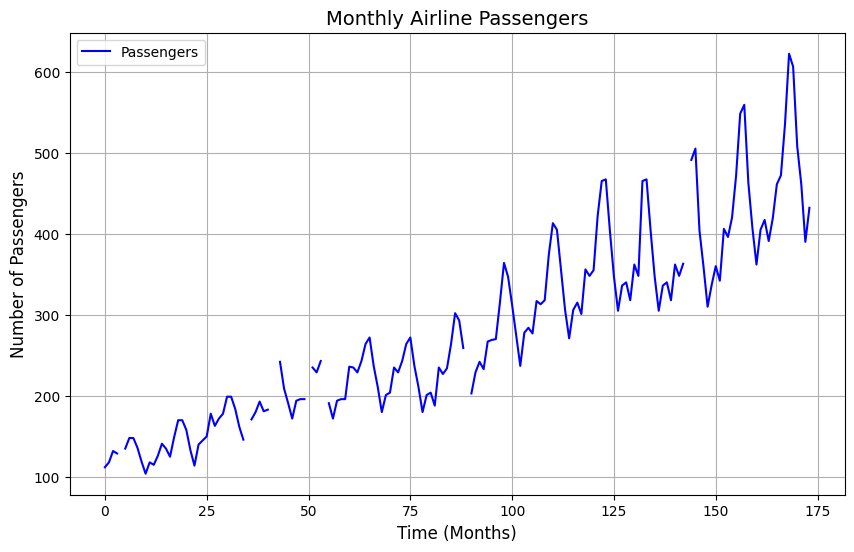

In [31]:
# Plot the original 'Passengers' data
plt.figure(figsize=(10, 6))
plt.plot(df['Passengers'], label='Passengers', color='b')

# Set title and labels
plt.title('Monthly Airline Passengers', fontsize=14)
plt.xlabel('Time (Months)', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)

# Show gridlines
plt.grid(True)
# Show legend
plt.legend()
# Display the plot
plt.show()

# 2. Remove Duplicates

In [32]:
# TODO: Check for duplicate rows in the dataset
# Place your code here
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    # TODO: Remove duplicate rows
    # Place your code here to remove duplicates
    df = df.drop_duplicates()
    print(f"Removed {duplicates} duplicate rows.")
else:
    print("No duplicates found.")
print(f"Number of duplicate rows after removing dulpicates: {df.duplicated().sum()}")

Number of duplicate rows: 28
Removed 28 duplicate rows.
Number of duplicate rows after removing dulpicates: 0


# 3. Handle Missing Values

In [33]:
# TODO: Check for missing values in each column
# Place your code here
missing_values = df.isna().sum()
missing_values_percentage = missing_values / df.shape[0]
print(f"Missing values per column:\n{missing_values}")
print(f"Percentage of missing values per column:\n{missing_values_percentage}\n")
if missing_values.sum() > 0:
    # TODO: Impute missing values with the column mean (simple imputation strategy)
    # Place your code here to impute missing values
    numeric_cols = df.select_dtypes(include=['float64', 'int64'])
    df[numeric_cols.columns] = numeric_cols.fillna(numeric_cols.mean())
    #df.fillna(numeric_only=True, inplace=True)
    print("Missing values have been imputed with the column mean.")
else:
    print("No missing values found.")

Missing values per column:
Month         0
Passengers    8
dtype: int64
Percentage of missing values per column:
Month         0.000000
Passengers    0.054795
dtype: float64

Missing values have been imputed with the column mean.


# 4. Train/Val/Test split

### Question:
**What is data leakage in time series forecasting, and how can you prevent it when splitting data for training, validation, and testing?**

#### `Answer`
Data leakage in time series forecasting occurs when future information inadvertently becomes available during model training, leading to overly optimistic performance. This often happens when data is split randomly instead of maintaining the chronological order, or when features include information about future events. To avoid leakage, it's crucial to respect the temporal structure of the data, ensuring that the training set contains only past data, while validation and test sets represent future data relative to training.

Preventing data leakage involves using strategies like time-based data splitting or rolling window validation to mimic real-world scenarios. Feature engineering should ensure only past or present data is used, such as creating lagged features instead of incorporating future values. Additionally, preprocessing steps like scaling or calculating statistics must be based solely on the training set and then applied to validation and test sets. These steps maintain temporal integrity and ensure reliable model evaluation.

In [43]:
# 4. Train, Validation, and Test Split
print("Splitting data into training, validation, and testing sets...")

def dataset_split(data: np.ndarray):
    """This function splits the dataset into training, validation, and testing sets and returns them."""

    # TODO: Split the data into training and testing sets (80% training, 20% testing)
    # Place your code here
    test_size = int(0.2*len(data))
    test_data = data[-test_size:]# Last 20% for testing
    train_data = data[:-test_size]# First 80% for training

    # TODO: Now split the training data into training and validation sets (80% training, 20% validation)
    # Place your code here
    val_size = int(len(train_data) * 0.2)
    val_data = train_data[-val_size:]# Last 20% of training data for validation
    train_data = train_data[:-val_size]# Remaining data for training

    print(f"Training data shape: {train_data.shape}")
    print(f"Validation data shape: {val_data.shape}")
    print(f"Testing data shape: {test_data.shape}\n")

    return train_data, val_data, test_data

# Split the data using the function
data = df['Passengers'].values
train_data, val_data, test_data = dataset_split(data)

Splitting data into training, validation, and testing sets...
Training data shape: (94,)
Validation data shape: (23,)
Testing data shape: (29,)



# 5. Normalize features

In [46]:
# 5. Normalize the Data
print("Normalizing the data...")

# Initialize the scaler
scaler = MinMaxScaler()  # Feature scaling between 0 and 1

# TODO: Normalize the training data
# Place your code here to fit and scale the training data
train_data_scaled = scaler.fit_transform(train_data.reshape(-1, 1))

# TODO: Normalize the validation data using the same scaler
# Place your code here to scale the validation data
val_data_scaled = scaler.fit_transform(val_data.reshape(-1, 1))

# TODO: Normalize the test data using the same scaler
# Place your code here to scale the test data
test_data_scaled = scaler.fit_transform(test_data.reshape(-1, 1))

# Note: You can also try other scaling techniques like StandardScaler
# For example:
# scaler = StandardScaler()  # Standard scaling (zero mean, unit variance)

print("Data normalization complete.\n")

Normalizing the data...
Data normalization complete.



# 6. Apply sliding windows to create (X, y) sequences

In [48]:
# 6. Apply Windowing to Create (X, y) Pairs
print("Creating time-series windows (X, y) pairs...")

def create_dataset(dataset, look_back=10):
    """This function creates (X, y) pairs where:
          X is a time series with length 'look_back' and
          y is the next value to predict."""
    
    X, y = [], []
    for i in range(len(dataset) - look_back):
        # TODO: Create the window (X) and target (y)
        # Place your code here
        X.append(dataset[i:i+look_back])
        y.append(dataset[i+look_back])
    return np.array(X), np.array(y)

look_back = 5  # Window length used to predict future

# Create sequences for training, validation, and testing data
X_train, y_train = create_dataset(train_data_scaled, look_back)
X_val, y_val = create_dataset(val_data_scaled, look_back)
X_test, y_test = create_dataset(test_data_scaled, look_back)

print(f"Shape of X_train: {X_train.shape}, Shape of y_train: {y_train.shape}")
print(f"Shape of X_val:   {X_val.shape}, Shape of y_val: {y_val.shape}")
print(f"Shape of X_test:  {X_test.shape}, Shape of y_test: {y_test.shape}")

Creating time-series windows (X, y) pairs...
Shape of X_train: (89, 5, 1), Shape of y_train: (89, 1)
Shape of X_val:   (18, 5, 1), Shape of y_val: (18, 1)
Shape of X_test:  (24, 5, 1), Shape of y_test: (24, 1)


# Convert Data to PyTorch Tensors and Create DataLoaders

In [49]:
# Convert numpy arrays to PyTorch tensors (dtype=float32 is required for neural networks)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Wrap tensors into TensorDataset objects for structured access
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

# Set batch size for training
batch_size = 32

# Create DataLoaders for training, validation, and testing
# shuffle=True only for training to randomize batches
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoader setup complete.\n")

DataLoader setup complete.



# Define RNN Model

In [57]:
# Define RNN Model for Time Series Regression
class RNNModel(nn.Module):
    """
    A Recurrent Neural Network (RNN) for time series regression.
    This model predicts a single future value based on a sequence of past values.
    """
    def __init__(self, input_size, hidden_size=50, num_layers=1, output_size=1):
        super(RNNModel, self).__init__()
        # TODO: define RNN and output layer
        # Place your code here
        self.h_size = hidden_size
        
        self.Whh = nn.Parameter(torch.randn(self.h_size, self.h_size) * 0.01)
        self.Wxh = nn.Parameter(torch.randn(input_size, self.h_size) * 0.01)
        self.Who = nn.Parameter(torch.randn(self.h_size, output_size) * 0.01)
        
        self.bh = torch.zeros((self.h_size, 1))
        self.bo = torch.zeros((output_size, 1))
        
    def forward(self, x):
        """
        Forward pass of the model
            - x: input tensor
            - returns : output of final linear layer
        """
        # TODO: forward pass of the model
        # Place your code here
        
        h = torch.zeros((self.h_size))
        
        self.last_inps = x 
        self.last_hs = { 0:h }
        
        for i, x in enumerate(input):
            h = torch.tanh((self.Wxh @ x) + (self.Whh @ h) + self.bh)
            self.last_hs[i+1] = h 
        o = (self.Who @ h) + self.bo
        
        out = (o, h)        
        
        return out

In [62]:
import torch
import torch.nn as nn

class RNNModel(nn.Module):
    """
    A Recurrent Neural Network (RNN) for time series regression.
    This model predicts a single future value based on a sequence of past values.
    """
    def __init__(self, input_size, hidden_size=50, num_layers=1, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers  # Currently supports only 1 layer as per implementation
        
        # Weight matrices for RNN cell
        self.Wxh = nn.Parameter(torch.randn(input_size, hidden_size) * 0.01)
        self.Whh = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.01)
        self.Who = nn.Parameter(torch.randn(hidden_size, output_size) * 0.01)
        
        # Biases (as parameters so they can be optimized)
        self.bh = nn.Parameter(torch.zeros(hidden_size))
        self.bo = nn.Parameter(torch.zeros(output_size))
        
        # For tracking hidden states (optional, for debugging or visualization)
        self.last_inps = None
        self.last_hs = None

    def forward(self, x):
        """
        Forward pass of the model
            - x: input tensor of shape (batch_size, seq_length, input_size)
            - returns: output of final linear layer
        """
        batch_size = x.size(0)
        seq_length = x.size(1)
        
        # Initialize hidden state (batch_size, hidden_size)
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        
        # For tracking hidden states
        self.last_inps = x
        self.last_hs = {0: h.clone()}
        
        # Iterate through time steps
        for t in range(seq_length):
            x_t = x[:, t, :]  # Shape: (batch_size, input_size)
            
            # RNN cell computation: h_t = tanh(Wxh @ x_t + Whh @ h + bh)
            h = torch.tanh(
                torch.matmul(x_t, self.Wxh) + 
                torch.matmul(h, self.Whh) + 
                self.bh
            )
            self.last_hs[t + 1] = h.clone()
        
        # Compute output: o = Who @ h + bo
        out = torch.matmul(h, self.Who) + self.bo
        
        return out  # Shape: (batch_size, output_size)

# Training Function

In [71]:
def train_model(model, train_loader, val_loader=None, epochs=20, learning_rate=0.001, device='cpu', patience=5):
    """
    Model Training Function with Validation and Early Stopping
    
    Args:
    - model: PyTorch model to train
    - train_loader: DataLoader for the training set
    - val_loader: DataLoader for the validation set
    - epochs: Number of epochs to train
    - learning_rate: Learning rate for the optimizer
    - device: Device to run the model on ('cpu' or 'cuda')
    - patience: Early stopping patience (number of epochs without improvement to stop training)
    
    Returns:
    - train_loss_history: List of average training losses per epoch
    - val_loss_history:   List of average validation losses per epoch
    """
    
    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # TODO: Define a proper loss function for regression task
    # Place your code here
    criterion = torch.nn.MSELoss()
    
    # Store loss values for tracking
    train_loss_history = []
    val_loss_history = []

    # Move the model to the specified device (GPU or CPU)
    model.to(device)
    # TODO: Set the model to training mode
    # Place your code here
    model.train()
    
    # Initialize early stopping parameters
    best_val_loss = float('inf')  # Start with a very high validation loss
    epochs_without_improvement = 0  # Counter to track epochs without improvement

    # Loop over the number of epochs
    for epoch in range(epochs):
        running_loss = 0.0
        
        # Training phase
        for inputs, targets in train_loader:
            # TODO: Implement the training loop 
            # Move batch to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # TODO: Zero the gradients
            # Place your code here
            optimizer.zero_grad()
            
            # TODO: Get model predictions
            # Place your code here
            y = model(inputs)
            
            # TODO: Calculate the loss
            # Place your code here
            loss = criterion(y, targets.view(-1,1))
            
            # TODO: Backpropagate the gradients
            # Place your code here
            loss.backward()
            optimizer.step()

            # TODO: Update the model parameters
            # Place your code here
            
            running_loss += loss.item()  # Accumulate the training loss
        
        # Calculate the average training loss for the epoch
        epoch_train_loss = running_loss / len(train_loader)
        train_loss_history.append(epoch_train_loss)
        
        # Validation phase 
        if val_loader is not None:
            model.eval()  # Set the model to evaluation mode (no gradients)
            val_loss = 0.0
            with torch.no_grad():  # Disable gradient calculation during validation
                for val_inputs, val_targets in val_loader:
                    val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)  # Move batch to device
                    val_outputs = model(val_inputs)  # Get model predictions
                    val_loss += criterion(val_outputs, val_targets.view(-1, 1)).item()  # Calculate validation loss
            
            # Calculate the average validation loss for the epoch
            epoch_val_loss = val_loss / len(val_loader)
            val_loss_history.append(epoch_val_loss)

            # Print losses for this epoch
            if epoch%5==0:
                print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')
            
            # Early stopping logic
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss  # Update the best validation loss
                epochs_without_improvement = 0  # Reset the counter since we improved
            else:
                epochs_without_improvement += 1  # Increment the counter since no improvement
            
            # Stop training if no improvement in validation loss for 'patience' epochs
            # TODO: Implement early stopping based on `patience` and validation loss.
            # Place your code here to check `epochs_without_improvement` and stop training if necessary.
            
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break
            
            
        else:
            # If no validation data is provided, just print training loss
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}')
    
    # Return the loss histories for later analysis or plotting
    return train_loss_history, val_loss_history

# Evaluation Function

In [67]:
# Evaluation Function
def evaluate_model(model, test_loader, device, scaler):
    """
    Evaluate the model performance using the test dataset.
    
    Parameters:
    - model: The trained model to evaluate.
    - test_loader: DataLoader for the test dataset.
    - device: The device (CPU or GPU) to run the model on.
    - scaler: The scaler used to transform the data (to inverse scale predictions).
    
    Returns:
    - rmse: The Root Mean Squared Error of the model predictions.
    - true_values: The true values from the test dataset (in original scale).
    - predicted_values: The predicted values from the model (in original scale).
    """
    model.eval()  # Set the model to evaluation mode
    true_values = []  # List to store true values
    predicted_values = []  # List to store predicted values

    # Disable gradient calculations during evaluation to save memory and computation
    with torch.no_grad():
        # Loop through the test dataset
        for inputs, targets in test_loader:
            # Move inputs and targets to the specified device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Get model outputs (predictions)
            outputs = model(inputs)
            
            # Store the true and predicted values
            true_values.append(targets)
            predicted_values.append(outputs)

    
    # Concatenate all batches of true and predicted values
    true_values      = torch.cat(true_values, dim=0)
    predicted_values = torch.cat(predicted_values, dim=0)

    # TODO: Inverse transform the true and predicted values to their original scale
    true_values = true_values.cpu().numpy().reshape(-1, 1)     #in original scale
    predicted_values = predicted_values.cpu().numpy().reshape(-1,1)#in original scale

    # TODO: Compute the Root Mean Squared Error (RMSE) between tru_values and predicted_values
    # Place your code here
    rmse = np.sqrt(np.mean((true_values - predicted_values)**2)) 

    return rmse, true_values, predicted_values

# Train and Evaluate the RNN Model
### Question: Model Tuning for Better Performance

Adjust the hyperparameters (e.g., learning rate, hidden size, number of epochs) to minimize the RMSE of the RNN model.

You may also consider experimenting with:
- The model architecture (e.g., adding layers, changing units)
- Optimizer settings (e.g., switching from Adam to SGD, tuning weight decay)
- Early stopping criteria

Aim to find a combination that improves generalization while avoiding overfitting.


In [68]:
# Train and Evaluate the RNN Model

# Hyperparameter tuning to minimize the RNN RMSE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_sizes = [32, 64, 128]  # Experiment with hidden sizes
learning_rates = [0.001, 0.005, 0.01]  # Experiment with learning rates
epochs = 50  # Increase epochs, early stopping will prevent overfitting

best_rmse = float('inf')
best_model = None
best_train_loss_history = None
best_val_loss_history = None
best_rnn_true = None
best_rnn_pred = None

# Iterate over hyperparameter combinations
for hidden_size in hidden_sizes:
    for lr in learning_rates:
        print(f"\nTesting: hidden_size={hidden_size}, learning_rate={lr}")
        
        # Initialize the RNN model with current hyperparameters
        rnn_model = RNNModel(input_size=X_train.shape[2], hidden_size=hidden_size, num_layers=1, output_size=1)
        
        # Train the model
        train_loss_history, val_loss_history = train_model(
            model=rnn_model,
            train_loader=train_loader,
            val_loader=train_loader,  # Assuming a validation loader exists; if not, set to None
            epochs=epochs,
            learning_rate=lr,
            device=device,
            patience=5
        )
        
        # Evaluate the trained model on the test data
        rnn_rmse, rnn_true, rnn_pred = evaluate_model(
            model=rnn_model,
            test_loader=test_loader,
            device=device,
            scaler=scaler  # Assuming scaler is defined (e.g., MinMaxScaler)
        )
        
        # Track the best model based on RMSE
        if rnn_rmse < best_rmse:
            best_rmse = rnn_rmse
            best_model = rnn_model
            best_train_loss_history = train_loss_history
            best_val_loss_history = val_loss_history
            best_rnn_true = rnn_true
            best_rnn_pred = rnn_pred
            best_params = {'hidden_size': hidden_size, 'learning_rate': lr}

# Use the best model's results
print(f"\nBest Hyperparameters: {best_params}")
train_loss_history, val_loss_history = best_train_loss_history, best_val_loss_history
rnn_rmse, rnn_true, rnn_pred = best_rmse, best_rnn_true, best_rnn_pred

# Print the Root Mean Squared Error (RMSE) of the model on the test dataset
print(f'RNN RMSE: {rnn_rmse:.4f}')


Testing: hidden_size=32, learning_rate=0.001
Epoch [1/50], Train Loss: 0.1878, Validation Loss: 0.1866
Epoch [2/50], Train Loss: 0.1848, Validation Loss: 0.1837
Epoch [3/50], Train Loss: 0.1822, Validation Loss: 0.1805
Epoch [4/50], Train Loss: 0.1742, Validation Loss: 0.1725
Epoch [5/50], Train Loss: 0.1724, Validation Loss: 0.1643
Epoch [6/50], Train Loss: 0.1621, Validation Loss: 0.1581
Epoch [7/50], Train Loss: 0.1519, Validation Loss: 0.1446
Epoch [8/50], Train Loss: 0.1335, Validation Loss: 0.1226
Epoch [9/50], Train Loss: 0.1150, Validation Loss: 0.1005
Epoch [10/50], Train Loss: 0.0886, Validation Loss: 0.0692
Epoch [11/50], Train Loss: 0.0595, Validation Loss: 0.0418
Epoch [12/50], Train Loss: 0.0383, Validation Loss: 0.0392
Epoch [13/50], Train Loss: 0.0423, Validation Loss: 0.0499
Epoch [14/50], Train Loss: 0.0480, Validation Loss: 0.0426
Epoch [15/50], Train Loss: 0.0405, Validation Loss: 0.0348
Epoch [16/50], Train Loss: 0.0354, Validation Loss: 0.0353
Epoch [17/50], Trai

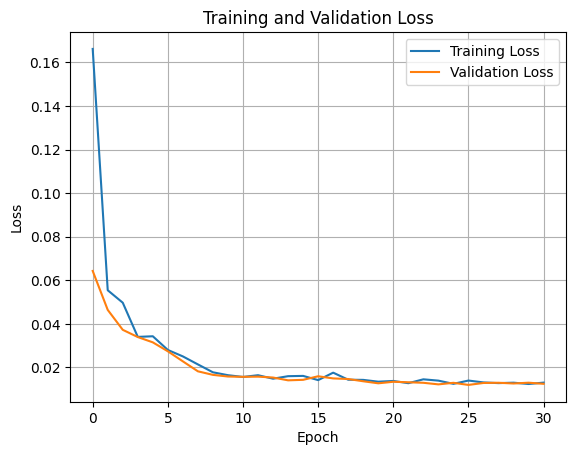

In [69]:
# Plot training and validation loss curves
def loss_curves(train_loss_history, val_loss_history):
    """
    Plot the training and validation loss curves for model performance evaluation.
    
    Arguments:
    train_loss_history : list : A list of training loss values at each epoch.
    val_loss_history   : list : A list of validation loss values at each epoch
    """
    
    # Plot training loss curve
    plt.plot(train_loss_history, label='Training Loss')

    # Plot validation loss curve
    plt.plot(val_loss_history, label='Validation Loss')

    # Add labels and title for the plot
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    # Display legend to differentiate between training and validation loss
    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.show()


# TODO: PLot the training and validation loss curves
# Place your code here
loss_curves(train_loss_history, val_loss_history)

# Plot true values vs. predictions


Best Hyperparameters: {'hidden_size': 64, 'learning_rate': 0.01}
RNN RMSE: 0.1929


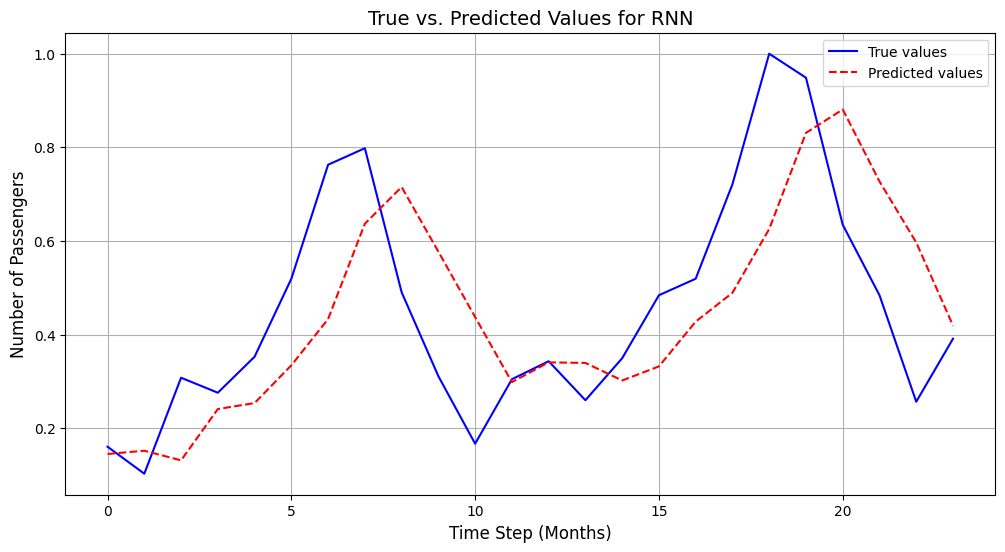

In [73]:
# Plot true values vs. predictions for the RNN model
def plot_true_pred(rnn_true, rnn_pred):    
    """
    Plots the true values against the predicted values for visual comparison.
    Args:
        true_values (numpy array): The actual target values from the test set.
        predicted_values (numpy array): The predicted values generated by the model.
    """
    # Set the figure size for better visualization
    plt.figure(figsize=(12, 6))
    
    # Plot the true values
    plt.plot(rnn_true, label='True values', color='blue', linestyle='-')
    
    # Plot the predicted values
    plt.plot(rnn_pred, label='Predicted values', color='red', linestyle='--')
    
    # Add title and labels
    plt.title('True vs. Predicted Values for RNN', fontsize=14)
    plt.xlabel('Time Step (Months)', fontsize=12)
    plt.ylabel('Number of Passengers', fontsize=12)
    
    # Show the legend for better understanding
    plt.legend()
    
    # Display the plot
    plt.grid(True)
    plt.show()


# TODO: Evaluate the RNN model on test data and get the true values and predictions
# rnn_rmse, rnn_true, rnn_pred = 
# TODO: Plot the true vs. predicted values

print(f"\nBest Hyperparameters: {best_params}")
train_loss_history, val_loss_history = best_train_loss_history, best_val_loss_history
rnn_rmse, rnn_true, rnn_pred = best_rmse, best_rnn_true, best_rnn_pred

# Print the Root Mean Squared Error (RMSE) of the model on the test dataset
print(f'RNN RMSE: {rnn_rmse:.4f}')

# Plot the true vs. predicted values
plot_true_pred(rnn_true, rnn_pred)

### Model Evaluation and Performance Visualization

In this cell, we evaluate the performance of the trained model across different data subsets (training, validation, and test). We use the `evaluate_model` function to compute the RMSE (Root Mean Squared Error) for each part.

By plotting the true values vs predictions for the training, validation, and test datasets, we can visually inspect how well the model performs on each part. Vertical lines are added to demonstrate the boundaries between the training, validation, and test data.

**Question:**

What do you expect to see in terms of the RMSE and the model’s performance on each dataset? How can you interpret the plot with respect to overfitting or underfitting?

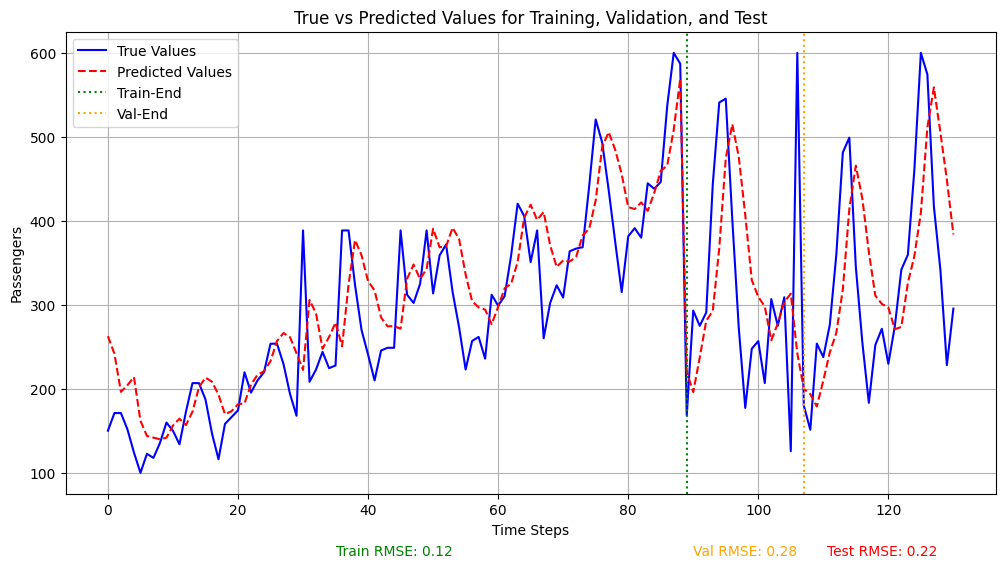

In [76]:
def evaluate_and_plot_with_rmse(model, train_loader, val_loader, test_loader, device, scaler):
    """
    This function evaluates the trained model on the training, validation, and test sets.
    It then concatenates the true and predicted values, and plots them along with RMSE values 
    for each part (train, validation, and test).
    """
    
    # Evaluate on training data
    train_rmse, train_true, train_pred = evaluate_model(
        model=model,
        test_loader=train_loader,
        device=device,
        scaler=scaler
    )
    
    # Evaluate on validation data
    val_rmse, val_true, val_pred = evaluate_model(
        model=model,
        test_loader=val_loader,
        device=device,
        scaler=scaler
    )
    
    # Evaluate on test data
    test_rmse, test_true, test_pred = evaluate_model(
        model=model,
        test_loader=test_loader,
        device=device,
        scaler=scaler
    )
    
    # Concatenate the true values and predicted values from all parts
    all_true = np.concatenate([train_true, val_true, test_true])
    all_pred = np.concatenate([train_pred, val_pred, test_pred])
    
    # Plotting setup
    plt.figure(figsize=(12, 6))
    
    # Plot true values vs predicted values (blue for true, red for predicted)
    plt.plot(100+ 500*all_true, label='True Values', color='blue')
    plt.plot(100+ 500*all_pred, label='Predicted Values', color='red', linestyle='--')

    # Add vertical lines to indicate the boundaries between train, validation, and test parts
    train_end = len(train_true)
    val_end = train_end + len(val_true)
    
    # Vertical lines separating train, validation, and test
    plt.axvline(x=train_end, color='green', linestyle=':', label='Train-End')
    plt.axvline(x=val_end, color='orange', linestyle=':', label='Val-End')
    
    # Display RMSE values for each section (train, val, test)
    plt.text(train_end // 2, max(all_true), f'Train RMSE: {train_rmse:.2f}', color='green', fontsize=10, ha='center')
    plt.text((train_end + val_end) // 2, max(all_true), f'Val RMSE: {val_rmse:.2f}', color='orange', fontsize=10, ha='center')
    plt.text((val_end + len(all_true)) // 2, max(all_true), f'Test RMSE: {test_rmse:.2f}', color='red', fontsize=10, ha='center')
    
    # Customize the plot (title, labels, legend, etc.)
    plt.title("True vs Predicted Values for Training, Validation, and Test")
    plt.xlabel("Time Steps")
    plt.ylabel("Passengers")
    plt.legend(loc='best')
    plt.grid(True)
    
    # Show the plot
    plt.show()

# Set up train DataLoader with shuffle=False
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Call the function to evaluate and plot
evaluate_and_plot_with_rmse(rnn_model, train_loader, val_loader, test_loader, device, scaler)

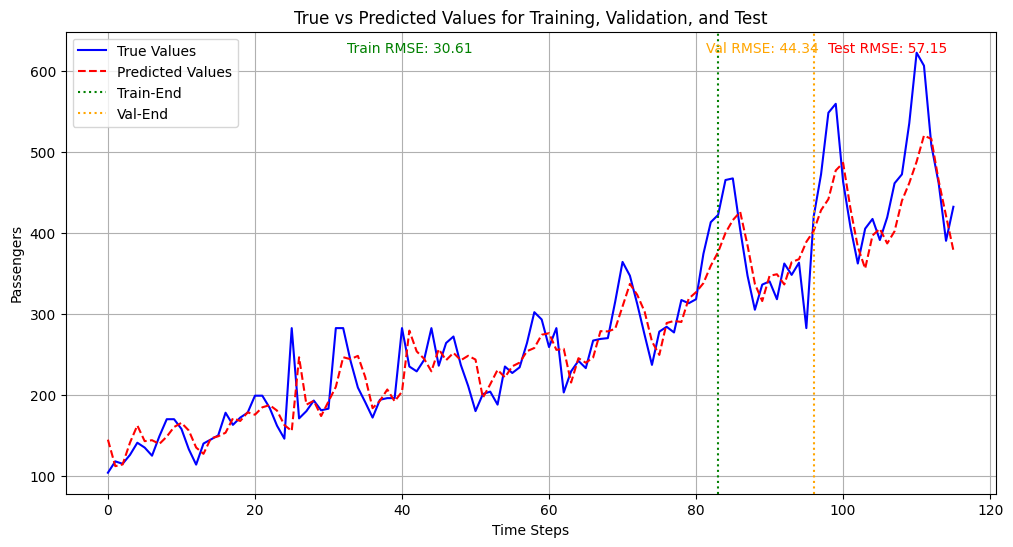

In [31]:
# Evaluate on each part: train, validation, and test
def evaluate_and_plot_with_rmse(model, train_loader, val_loader, test_loader, device, scaler):
    """
    This function evaluates the trained model on the training, validation, and test sets.
    It then concatenates the true and predicted values, and plots them along with RMSE values 
    for each part (train, validation, and test).
    """
    
    # TODO: Evaluate on training data
    # train_rmse, train_true, train_pred = 
    
    # TODO: Evaluate on validation data
    # val_rmse, val_true, val_pred = 
    
    # TODO: Evaluate on test data
    # test_rmse, test_true, test_pred = 
    
    # Concatenate the true values and predicted values from all parts
    all_true = np.concatenate([train_true, val_true, test_true])
    all_pred = np.concatenate([train_pred, val_pred, test_pred])
    
    # Plotting setup
    plt.figure(figsize=(12, 6))
    
    # Plot true values vs predicted values (blue for true, red for predicted)
    plt.plot(all_true, label='True Values', color='blue')
    plt.plot(all_pred, label='Predicted Values', color='red', linestyle='--')

    # Add vertical lines to indicate the boundaries between train, validation, and test parts
    train_end = len(train_true)
    val_end = train_end + len(val_true)
    
    # Vertical lines separating train, validation, and test
    plt.axvline(x=train_end, color='green', linestyle=':', label='Train-End')
    plt.axvline(x=val_end, color='orange', linestyle=':', label='Val-End')
    
    # Display RMSE values for each section (train, val, test)
    plt.text(train_end // 2, max(all_true), f'Train RMSE: {train_rmse:.2f}', color='green', fontsize=10, ha='center')
    plt.text((train_end + val_end) // 2, max(all_true), f'Val RMSE: {val_rmse:.2f}', color='orange', fontsize=10, ha='center')
    plt.text((val_end + len(all_true)) // 2, max(all_true), f'Test RMSE: {test_rmse:.2f}', color='red', fontsize=10, ha='center')
    
    # Customize the plot (title, labels, legend, etc.)
    plt.title("True vs Predicted Values for Training, Validation, and Test")
    plt.xlabel("Time Steps")
    plt.ylabel("Passengers")
    plt.legend(loc='best')
    plt.grid(True)
    
    # Show the plot
    plt.show()

# Set up train DataLoader with shuffle=False
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# Call the function to evaluate and plot
evaluate_and_plot_with_rmse(rnn_model, train_loader, val_loader, test_loader, device, scaler)

# Bonus: Compare the RNN RMSE with GRU

In this section, we will compare the performance of the RNN model with the GRU (Gated Recurrent Unit) model on the same dataset. We will evaluate both models using the Root Mean Squared Error (RMSE) and visualize the results.

The GRU is a more advanced variant of the RNN, designed to address some of the issues that vanilla RNNs face, such as vanishing gradients. We expect the GRU to potentially perform better in certain cases, especially when the sequence length is long or the dataset is complex.

By comparing the RMSE for both models (RNN and GRU), we can better understand how each model performs on the task at hand and which one is more suitable for time-series prediction.

Epoch [1/20], Train Loss: 0.3350, Validation Loss: 0.3702
Epoch [6/20], Train Loss: 0.1271, Validation Loss: 0.1583
Epoch [11/20], Train Loss: 0.0388, Validation Loss: 0.0688
Epoch [16/20], Train Loss: 0.0432, Validation Loss: 0.0675
GRU Test RMSE: 0.2264
RNN RMSE: 0.1872, GRU RMSE: 0.2264


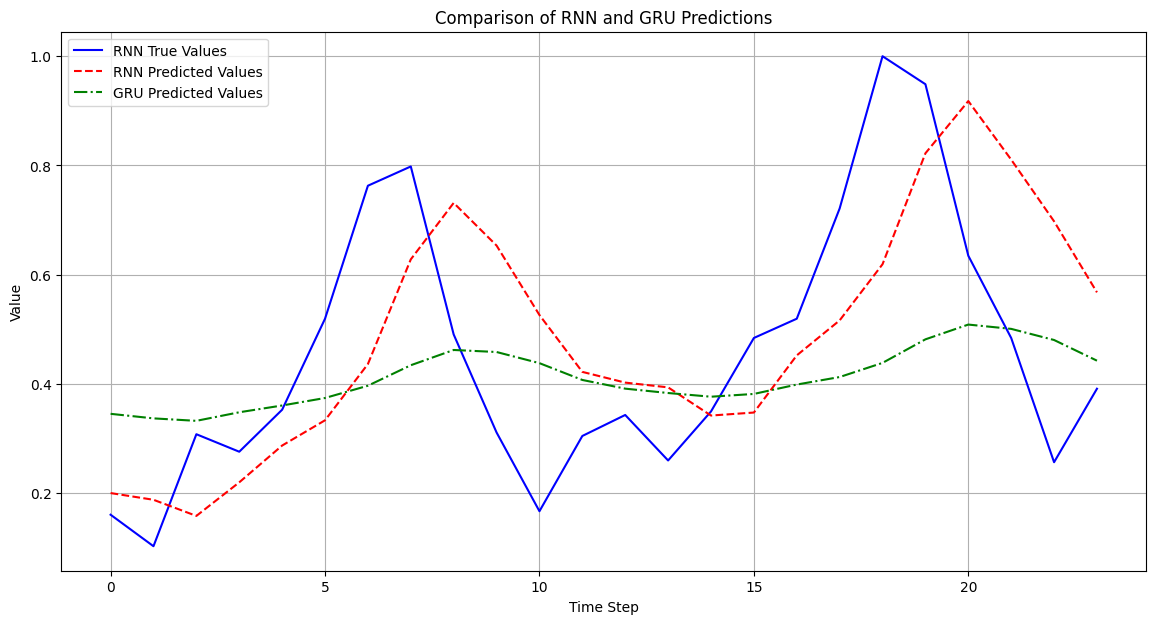

In [77]:
# TODO: 
# Place your code here
class GRUModel(nn.Module):
    """
    A Gated Recurrent Unit (GRU) model for time series regression.
    """
    def __init__(self, input_size, hidden_size=50, num_layers=1, output_size=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  # Last time step's output
        out = self.fc(out)
        return out

def evaluate_rnn(model, test_loader, device='cpu'):
    """
    Evaluates the model on the test set and returns true values and predictions.
    Args:
        model: Trained PyTorch RNN model.
        test_loader: DataLoader for the test set.
        device: Device to run the evaluation ('cpu' or 'cuda').
    Returns:
        rnn_true (numpy array): True target values.
        rnn_pred (numpy array): Predicted values.
    """
    model.eval()  # Set the model to evaluation mode
    rnn_true = []
    rnn_pred = []
    with torch.no_grad():  # Disable gradient calculations during evaluation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
            outputs = model(inputs)  # Model predictions
            rnn_true.extend(targets.cpu().numpy())  # Append true values
            rnn_pred.extend(outputs.cpu().numpy())  # Append predictions

    return np.array(rnn_true), np.array(rnn_pred)


from sklearn.metrics import mean_squared_error

def calculate_rmse(true_values, predicted_values):
    """
    Calculates the Root Mean Squared Error (RMSE) between true values and predicted values.
    Args:
        true_values (numpy array): True target values.
        predicted_values (numpy array): Predicted values from the model.
    Returns:
        RMSE value as a float.
    """
    return np.sqrt(mean_squared_error(true_values, predicted_values))




# Instantiate and train the GRU model
gru_model = GRUModel(input_size=1, hidden_size=50, num_layers=1, output_size=1)
gru_train_loss, gru_val_loss = train_model(gru_model, train_loader, val_loader, epochs=20, learning_rate=0.001, device='cpu')

# Evaluate GRU on test data
gru_true, gru_pred = evaluate_rnn(gru_model, test_loader, device='cpu')
gru_rmse = calculate_rmse(gru_true, gru_pred)
print(f"GRU Test RMSE: {gru_rmse:.4f}")

# Compare RMSEs
print(f"RNN RMSE: {rnn_rmse:.4f}, GRU RMSE: {gru_rmse:.4f}")

# Plot true values vs predictions for RNN and GRU
plt.figure(figsize=(14, 7))
plt.plot(rnn_true, label='RNN True Values', color='blue')
plt.plot(rnn_pred, label='RNN Predicted Values', color='red', linestyle='--')
plt.plot(gru_pred, label='GRU Predicted Values', color='green', linestyle='-.')
plt.title('Comparison of RNN and GRU Predictions')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
